# Fruit Classifier ConvNet


In [1]:
import itertools
import logging
import math
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

try:
    import google.colab
    GOOGLE_COLAB = True
except:
    GOOGLE_COLAB = False

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---

## Network architecture

#### Flattening module

Flattens all dimensions (except the batch dimension) of the input into one

In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(-1, np.prod(x.size()[1:]))

#### Batch normalization module

Performs batch normalization on a batch of 2-D inputs with num_features channels.

There are independent learnable scale and shift parameters for each channel.

During training, running mean and variance are computed, which are saved with the model, and can be used later during the evaluation phase.

In [3]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        shape = (1, num_features, 1, 1)
        self.shift = nn.Parameter(torch.zeros(*shape))
        self.scale = nn.Parameter(torch.ones(*shape))
        self.register_buffer('running_mean', torch.zeros(*shape))
        self.register_buffer('running_var', torch.ones(*shape))

    def forward(self, x):
        if not self.training:
            norm = (x - self.running_mean) / (self.running_var + self.eps).sqrt()
        else:
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            var = ((x - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
            norm = (x - mean) / (var + self.eps).sqrt()
            self.running_mean = self.momentum * self.running_mean + (1.0 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1.0 - self.momentum) * var
        out = self.scale * norm + self.shift
        return out

#### Network architecture

In [4]:
class FruitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(8),
            Flatten(),
            nn.Linear(64, 100), nn.ReLU(),
            nn.Linear(100, 95),
        )

    def forward(self, x):
        return self.net(x)
    
net = FruitClassifier()
net.to(DEVICE) ;

---

## Data

#### Download

(if necessary)

In [ ]:
!wget http://www.mimuw.edu.pl/~cygan/assignment1.tgz
!tar xf assignment1.tgz

#### Dataset definitions

In [5]:
if GOOGLE_COLAB:
    DATA_ROOT = './fruits-360'
else:
    DATA_ROOT = '/scidata/fruits-360'
    
default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.ImageFolder(root=DATA_ROOT + '/Training', transform=default_transform)
testset = datasets.ImageFolder(root=DATA_ROOT + '/Test', transform=default_transform)

#### Loading images

Returns a tensor containing a batch of `num` images chosen randomly from `dataset`, and optionally a second tensor containing their labels.

In [6]:
def get_random_images(dataset, num, with_labels=True):
    images, labels = zip(*(dataset[random.randint(0, len(dataset))] for _ in range(num)))
    images = torch.cat(tuple(i.unsqueeze(0) for i in images))
    if with_labels:
        labels = torch.Tensor([i for i in labels]).long()
        return images, labels
    return images

Returns a tensor containing a batch of images loaded from `paths` (list), and optionally a tensor containing their labels based on `label_strs` (list of same length as `paths`) and `dataset`

In [7]:
def get_images(paths, label_strs=None, dataset=None):
    assert label_strs is None or (label_strs is not None and dataset is not None and len(paths) == len(label_strs))
    images = None
    if label_strs is not None:
        labels = torch.empty(len(label_strs)).long()
    for i, image_file in enumerate(paths, 0):
        image = Image.open(image_file)
        if images is None:
            images = torch.empty(len(paths), 3, *image.size)
        images[i] = default_transform(image)
        if label_strs is not None:
            labels[i] = dataset.class_to_idx[label_strs[i]]
    if label_strs is not None:
        return images, labels
    return images        

#### Preview data

In [8]:
def imshow(img, scale=False):
    if scale:
        # change range from [-1,1] to [0,1]
        img = img / 2 + 0.5
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()

def preview_dataset(dataset, num=3):
    images, labels = get_random_images(dataset, num)
    imshow(make_grid(images), scale=True)
    print(', '.join(dataset.classes[i.item()] for i in labels))

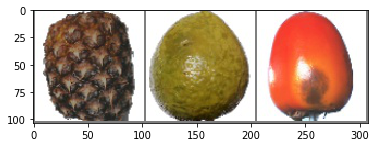

Pineapple, Guava, Kaki


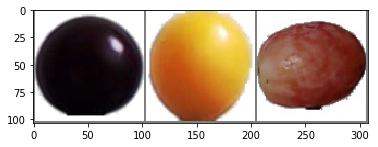

Cherry Wax Black, Cherry Wax Yellow, Grape Pink


In [11]:
preview_dataset(trainset)
preview_dataset(testset)

---

## Training

Pretrained model can be loaded from checkpoint

In [12]:
net.load_state_dict(torch.load('fruits.pt'))

On every epoch, if the evaluation loss has decreased below the previous lowest value, a checkpoint is saved as `checkpoint_filename`.

If the lowest evaluation loss value hasn't changed for more than `early_stop` epochs, training stops and the last checkpoint is loaded.

Training always stops after no more than `max_epochs` epochs.

In [13]:
def train(net, trainset, testset, batch_size, lr, max_epochs, early_stop, checkpoint_filename):
    def log(*args):
        print(time.strftime("%Y-%m-%d %H:%M:%S"), *args)

    def log_status(*args):
        log('epoch {}, train_loss {}, test_loss {}, accuracy {:.2f}'.format(*args))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    n_train_batches = len(trainloader)

    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)
    n_test_batches = len(testloader)

    # (epoch, train_loss, test_loss, accuracy)
    best = (0, math.inf, math.inf, 0.0)

    stop_in = early_stop

    log('started training')

    for epoch in range(max_epochs):
        # train
        net.train()
        train_loss = 0.0
        for (images, labels) in ((im.to(DEVICE), lbl.to(DEVICE)) for im, lbl in trainloader):
            optimizer.zero_grad()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= n_train_batches

        # evaluate
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        for images, labels in ((im.to(DEVICE), lbl.to(DEVICE)) for im, lbl in testloader):
            with torch.no_grad():
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                test_loss += criterion(outputs, labels).item()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= n_test_batches
        accuracy = 100 * correct / total

        status = (epoch, train_loss, test_loss, accuracy)
        if test_loss < best[2]:
            stop_in = early_stop
            best = status
            torch.save(net.state_dict(), checkpoint_filename)
        else:
            stop_in -= 1

        log_status(*status)

        if stop_in == 0:
            break

    log('finished training, best result:')
    log_status(*best)
    
    net.load_state_dict(torch.load(checkpoint_filename))

In [37]:
train(net, trainset, testset, batch_size=256, lr=0.001, max_epochs=15, early_stop=5, checkpoint_filename='fruits.pt')

2019-04-19 22:07:56 started training
2019-04-19 22:08:49 epoch 0, train_loss 1.1186275773798116, test_loss 0.18579684633475083, accuracy 96.57
2019-04-19 22:09:41 epoch 1, train_loss 0.04676949404529296, test_loss 0.06385736637390577, accuracy 98.62
2019-04-19 22:10:27 epoch 2, train_loss 0.010864568870601943, test_loss 3.564868417152992, accuracy 55.56
2019-04-19 22:11:14 epoch 3, train_loss 0.07346226520409498, test_loss 0.17978710463413825, accuracy 94.46
2019-04-19 22:12:13 epoch 4, train_loss 0.019114189091245255, test_loss 0.07580308283750828, accuracy 97.77
2019-04-19 22:13:06 epoch 5, train_loss 0.008407816574617755, test_loss 0.0254847158319675, accuracy 99.46
2019-04-19 22:14:04 epoch 6, train_loss 0.0016579800676481682, test_loss 0.025806323625147343, accuracy 99.43
2019-04-19 22:14:58 epoch 7, train_loss 0.004232830311896881, test_loss 1.3665484538445105, accuracy 67.60
2019-04-19 22:15:53 epoch 8, train_loss 0.04656534104651655, test_loss 0.275508788228035, accuracy 91.91


---

## Testing

In [14]:
def test(net, testset, batch_size, all_classes=False):
    net.eval()

    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)
    n_classes = len(testset.classes)
    
    correct = 0
    class_correct = [0.] * n_classes
    class_total = [0.] * n_classes
    total = 0
    for images, labels in ((im.to(DEVICE), lbl.to(DEVICE)) for im, lbl in testloader):
        with torch.no_grad():
            outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        if all_classes:
            for i in range(labels.size()[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
   
    if all_classes:
        for i in range(n_classes):
            print('Accuracy of {}: {}'.format(testset.classes[i], 100 * class_correct[i] / class_total[i]))

    print('Accuracy of whole test set: {}'.format(100 * correct / total))

In [15]:
test(net, testset, batch_size=256, all_classes=True)

Accuracy of Apple Braeburn: 73.78048780487805
Accuracy of Apple Golden 1: 98.78048780487805
Accuracy of Apple Golden 2: 100.0
Accuracy of Apple Golden 3: 100.0
Accuracy of Apple Granny Smith: 100.0
Accuracy of Apple Red 1: 100.0
Accuracy of Apple Red 2: 100.0
Accuracy of Apple Red 3: 100.0
Accuracy of Apple Red Delicious: 100.0
Accuracy of Apple Red Yellow 1: 100.0
Accuracy of Apple Red Yellow 2: 100.0
Accuracy of Apricot: 100.0
Accuracy of Avocado: 100.0
Accuracy of Avocado ripe: 100.0
Accuracy of Banana: 100.0
Accuracy of Banana Lady Finger: 100.0
Accuracy of Banana Red: 100.0
Accuracy of Cactus fruit: 100.0
Accuracy of Cantaloupe 1: 100.0
Accuracy of Cantaloupe 2: 100.0
Accuracy of Carambula: 97.59036144578313
Accuracy of Cherry 1: 100.0
Accuracy of Cherry 2: 100.0
Accuracy of Cherry Rainier: 100.0
Accuracy of Cherry Wax Black: 100.0
Accuracy of Cherry Wax Red: 100.0
Accuracy of Cherry Wax Yellow: 100.0
Accuracy of Chestnut: 93.4640522875817
Accuracy of Clementine: 100.0
Accuracy of

---

## Visualization

In [16]:
def predict(net, classes, images, real_labels=None):
    net.eval()
    imshow(make_grid(images), scale=True)
    images = images.to(DEVICE)
    with torch.no_grad():
        outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted:', ', '.join(classes[i.item()] for i in predicted))
    if real_labels is not None:
        print('Real:', ', '.join(classes[i.item()] for i in real_labels))

In [ ]:
# load random images from dataset...
images, labels = get_random_images(testset, 3)

In [18]:
# ...or load specific files
images, labels = get_images([DATA_ROOT + '/Test/Pineapple/r_212_100.jpg'], ['Pineapple'], testset)

#### Display images and predictions

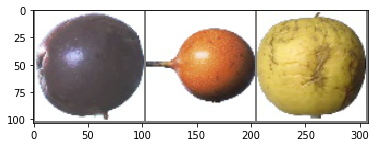

Predicted: Passion Fruit, Granadilla, Apple Golden 1
Real: Passion Fruit, Granadilla, Apple Golden 1


In [21]:
predict(net, testset.classes, images, labels)

#### Occlusion heatmaps

The sliding square will extend `occlusion_size` pixels in each direction from the center pixel.

In [22]:
def generate_occlusion_heatmaps(net, images, labels, occlusion_size, occlusion_color):
    net.eval()
    criterion = nn.CrossEntropyLoss()
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    n_images, w, h = (images.size(d) for d in (0,2,3))
    occlusion_color = torch.Tensor(occlusion_color).unsqueeze(1).unsqueeze(1).unsqueeze(0)
    losses = torch.zeros(n_images, h, w, device=DEVICE)
    for y, x in itertools.product(range(h), range(w)):
        images_occluded = images.clone()
        x_min, x_max = max(0, x - occlusion_size), min(w, x + occlusion_size)
        y_min, y_max = max(0, y - occlusion_size), min(h, y + occlusion_size)
        images_occluded[:, :, y_min:y_max, x_min:x_max] = occlusion_color
        with torch.no_grad():
            outputs = net(images_occluded)
            for i in range(n_images):
                losses[i, y, x] = criterion(outputs[i].unsqueeze(0), labels[i].unsqueeze(0)).item()

    max_losses = torch.Tensor([[[losses[i].max()]] for i in range(n_images)])
    max_losses = max_losses.to(DEVICE)
    losses_norm = losses / max_losses
    hue = 0.66 - losses_norm * 0.66
    sat = torch.ones_like(hue)
    val = 0.5 + losses_norm * 0.5
    hsv = torch.cat((hue.unsqueeze(-1), sat.unsqueeze(-1), val.unsqueeze(-1)), -1)
    occlusion_heatmaps = torch.from_numpy(hsv_to_rgb(hsv.cpu()))
    imshow(make_grid(occlusion_heatmaps.permute(0, 3, 1, 2)))

I chose cyan **<font color='#0ff'>(this color)</font>** for the square, because it is quite unlikely for it to appear in any of the images in the fruit dataset. Therefore, the occlusion should have a similar effect on every input image.

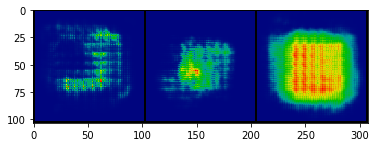

In [23]:
generate_occlusion_heatmaps(net, images, labels, occlusion_size=5, occlusion_color=(-1.0, 1.0, 1.0))

#### Loss pixelwise gradient heatmaps

In [24]:
def generate_loss_heatmaps(net, images, labels):
    net.train()
    criterion = nn.CrossEntropyLoss()
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    n_images, w, h = (images.size(d) for d in (0,2,3))
    images.requires_grad_(True)
    for p in net.parameters():
        p.requires_grad_(False)
    net.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    max_grads = torch.Tensor([[[[images.grad[i].abs().max()]]] for i in range(n_images)])
    max_grads = max_grads.to(DEVICE)
    loss_grad_heatmaps = (images.grad / max_grads)
    imshow(make_grid(loss_grad_heatmaps).cpu(), scale=True)

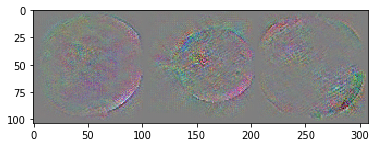

In [25]:
generate_loss_heatmaps(net, images, labels)

---

## Additional features

### Dropout

#### With batch normalization

In [26]:
class FruitClassifierDropout(FruitClassifier):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 5), BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(8),
            Flatten(),
            nn.Dropout(),
            nn.Linear(64, 100), nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 95),
        )

net_dropout = FruitClassifierDropout()
net_dropout.to(DEVICE) ;

In [27]:
# load pre-trained model
net_dropout.load_state_dict(torch.load('fruits-dropout.pt'))

In [22]:
train(net_dropout, trainset, testset, batch_size=256, lr=0.001, max_epochs=15, early_stop=5, checkpoint_filename='fruits-dropout.pt')

2019-04-19 21:32:55 started training
2019-04-19 21:33:58 epoch 0, train_loss 0.9391468356673917, test_loss 0.25662902066340815, accuracy 94.93
2019-04-19 21:35:00 epoch 1, train_loss 0.8046190307165185, test_loss 0.19982007283430833, accuracy 95.97
2019-04-19 21:36:16 epoch 2, train_loss 0.7411733063248297, test_loss 0.15316210515224016, accuracy 97.25
2019-04-19 21:37:20 epoch 3, train_loss 0.6642389295933148, test_loss 0.12171804572527226, accuracy 98.14
2019-04-19 21:38:42 epoch 4, train_loss 0.5726097004177669, test_loss 0.11776917049517999, accuracy 97.31
2019-04-19 21:40:01 epoch 5, train_loss 0.5453736778969566, test_loss 0.11693608107475134, accuracy 97.59
2019-04-19 21:41:09 epoch 6, train_loss 0.5855095408235987, test_loss 0.08714381485031202, accuracy 97.94
2019-04-19 21:42:38 epoch 7, train_loss 0.5112409697224697, test_loss 0.08792182476474689, accuracy 98.17
2019-04-19 21:43:40 epoch 8, train_loss 0.4535089440954228, test_loss 0.07424025561373968, accuracy 98.18
2019-04-1

In [28]:
test(net_dropout, testset, batch_size=256)

Accuracy of whole test set: 99.29967724255526


#### Without batch normalization

In [29]:
class FruitClassifierDropoutNoBN(FruitClassifier):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 5), nn.ReLU(), nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 5), nn.ReLU(), nn.MaxPool2d(8),
            Flatten(),
            nn.Dropout(),
            nn.Linear(64, 100), nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 95),
        )
    
net_dropout_nobn = FruitClassifierDropoutNoBN()
net_dropout_nobn.to(DEVICE) ;

In [30]:
# load pre-trained model
net_dropout_nobn.load_state_dict(torch.load('fruits-dropout-nobn.pt'))

In [30]:
train(net_dropout_nobn, trainset, testset, batch_size=256, lr=0.001, max_epochs=15, early_stop=5, checkpoint_filename='fruits-dropout-nobatchnorm.pt')

2019-04-19 22:00:00 started training
2019-04-19 22:00:44 epoch 0, train_loss 1.6287698907156785, test_loss 0.7062084968273457, accuracy 84.09
2019-04-19 22:01:06 epoch 1, train_loss 1.5112163573503494, test_loss 0.6165001768332261, accuracy 86.16
2019-04-19 22:01:30 epoch 2, train_loss 1.4256232424328725, test_loss 0.5485094487667084, accuracy 88.04
2019-04-19 22:01:54 epoch 3, train_loss 1.3449435643851757, test_loss 0.47988927593597996, accuracy 90.75
2019-04-19 22:02:18 epoch 4, train_loss 1.2964408372839291, test_loss 0.43252274073087255, accuracy 91.90
2019-04-19 22:02:43 epoch 5, train_loss 1.2433073613792658, test_loss 0.4463269169513996, accuracy 90.34
2019-04-19 22:03:07 epoch 6, train_loss 1.2298464595029752, test_loss 0.39427960698421183, accuracy 91.50
2019-04-19 22:03:31 epoch 7, train_loss 1.1825942521293957, test_loss 0.39760354436360873, accuracy 92.08
2019-04-19 22:03:55 epoch 8, train_loss 1.1436401422445972, test_loss 0.36666426612780645, accuracy 92.10
2019-04-19 22

In [31]:
test(net_dropout_nobn, testset, batch_size=256)

Accuracy of whole test set: 94.40350770355033


---
### Data augmentation

In [32]:
net_augmented = FruitClassifier()
net_augmented.to(DEVICE) ;

#### Augmented datasets

In [33]:
augmented_transform = transforms.Compose([
    transforms.ColorJitter(hue=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.Pad(padding=40, fill=(255, 255, 255)),
    transforms.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.9, 1.1), resample=Image.BILINEAR, fillcolor=(1.0, 1.0, 1.0)),
    transforms.CenterCrop((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

augmented_trainset = datasets.ImageFolder(root=DATA_ROOT + '/Training', transform=augmented_transform)
augmented_testset = datasets.ImageFolder(root=DATA_ROOT + '/Test', transform=augmented_transform)

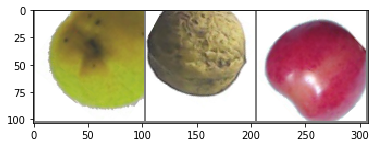

Peach 2, Walnut, Cherry Rainier


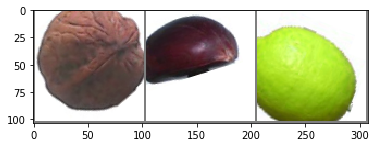

Walnut, Chestnut, Lemon


In [38]:
preview_dataset(augmented_trainset)
preview_dataset(augmented_testset)

#### Training

In [39]:
# load pre-trained model
net_augmented.load_state_dict(torch.load('fruits-augmented.pt'))

In [204]:
train(net_augmented, augmented_trainset, augmented_testset, batch_size=256, lr=0.001, max_epochs=15, early_stop=5, checkpoint_filename='fruits-augmented.pt')

2019-04-20 00:54:18 started training
2019-04-20 00:55:25 epoch 0, train_loss 1.9877559952437878, test_loss 1.3541690753056452, accuracy 59.12
2019-04-20 00:56:31 epoch 1, train_loss 0.4708906506032993, test_loss 0.5690117693864383, accuracy 81.15
2019-04-20 00:57:35 epoch 2, train_loss 0.26035023232301074, test_loss 0.45343682353313153, accuracy 84.37
2019-04-20 00:58:42 epoch 3, train_loss 0.2071075455363219, test_loss 0.4285842707523933, accuracy 83.97
2019-04-20 00:59:51 epoch 4, train_loss 0.18126436842915913, test_loss 0.5055493373137254, accuracy 84.94
2019-04-20 01:00:57 epoch 5, train_loss 0.1781151453809192, test_loss 0.283387389091345, accuracy 90.26
2019-04-20 01:02:06 epoch 6, train_loss 0.13976338241870204, test_loss 0.41282614801938716, accuracy 86.61
2019-04-20 01:03:16 epoch 7, train_loss 0.12788418459240347, test_loss 0.16417287507882486, accuracy 94.65
2019-04-20 01:04:22 epoch 8, train_loss 0.08843983205345769, test_loss 0.13678997319478256, accuracy 95.34
2019-04-20

#### Testing

Augmented training set, augmented test set:

In [40]:
test(net_augmented, augmented_testset, batch_size=256)

Accuracy of whole test set: 95.57274222032763


Augmented training set, non-augmented test set

In [41]:
test(net_augmented, testset, batch_size=256)

Accuracy of whole test set: 97.04646489251569


Non-augmented training set, augmented test set

In [42]:
test(net, augmented_testset, batch_size=256)

Accuracy of whole test set: 23.177638389866633


#### Visualization

In [43]:
# re-use the (non-augmented) images from previous visualizations...
augmented_images, augmented_labels = images, labels

In [44]:
# ...or load new ones (augmented)
augmented_images, augmented_labels = get_random_images(augmented_testset, 3)

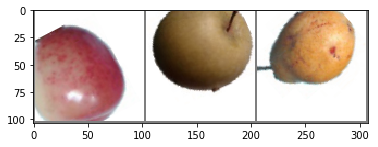

Predicted: Cherry Rainier, Apple Granny Smith, Pear Monster
Real: Cherry Rainier, Apple Granny Smith, Pear Monster


In [45]:
predict(net_augmented, augmented_testset.classes, augmented_images, augmented_labels)

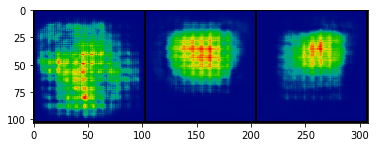

In [46]:
generate_occlusion_heatmaps(net_augmented, augmented_images, augmented_labels, occlusion_size=5, occlusion_color=(-1.0, 1.0, 1.0))

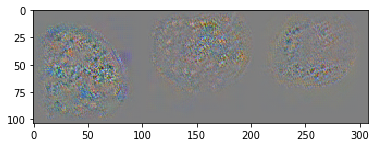

In [47]:
generate_loss_heatmaps(net_augmented, augmented_images, augmented_labels)